In [5]:
!pip install memory_profiler

  Obtaining dependency information for memory_profiler from https://files.pythonhosted.org/packages/49/26/aaca612a0634ceede20682e692a6c55e35a94c21ba36b807cc40fe910ae1/memory_profiler-0.61.0-py3-none-any.whl.metadata
DEPRECATION: pytorch-lightning 1.6.5 has a non-standard dependency specifier torch>=1.8.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [6]:
from transformers import EsmForSequenceClassification, EsmModel, AutoConfig, EsmConfig, EsmForTokenClassification
from peft import PeftModel
import torch
import esm
from Bio import SeqIO
import matplotlib.pyplot as plt
import numpy as np
import json
import os
from Bio.Seq import Seq
import logging
from tqdm import tqdm
import gc
from memory_profiler import profile
import statistics
import psutil
import time
from scipy.stats import gaussian_kde


gc.collect()


1011

In [7]:
from src.unique_virus_fasta import proteins_fasta, virus_fasta
from src.unique_virus_interactions import full_interactions
from src.get_attentions_viruses import parse_fasta, process_sequences
from src.distance_scores import *
from src.virus_contacts_numbers import count_contacts
from src.analyse_contacts_virus import all_metrics, read_full_interaction_file, read_interaction_file


In [68]:
!scp banane:/tmp/virus_0_full_attentions_weighted.pt .
    

virus_0_full_attentions_weighted.pt           100%   88MB 106.8MB/s   00:00    


In [69]:
data = torch.load("virus_0_full_attentions_weighted.pt")

In [62]:
def apc(x):
    a1 = x.sum(-1, keepdims=True)
    a2 = x.sum(-2, keepdims=True)
    a12 = x.sum((-1, -2), keepdims=True)
    avg = a1 * a2
    avg.div_(a12)  # in-place to reduce memory
    x.sub_(avg) # in-place to reduce memory
    del avg
    return x

In [77]:
def get_attention_block(self_attention_t_weighted, p1_boundaries, p2_boundaries, apc_norm=True):
    """
        self_attention: square matrix representing the self attentions
        returns: mutal attention between p1 and p2        
    """
    self_attention_t_weighted_reduced = self_attention_t_weighted[:, 1:-1, 1:-1]
#     weights = weights.squeeze()
#     # TODO replace the 660 by computing directly on weights
#     weighted_attentions = self_attention_t_reduced * weights.view(660, 1, 1)
#     sum_attention = weighted_attentions.sum(dim=1, keepdim=True)    
#     sum_attention = sum_attention.squeeze(1)



    block1 = self_attention_t_weighted_reduced[0][p1_boundaries[0]: p1_boundaries[1], p2_boundaries[0]: p2_boundaries[1]]
    block2 = self_attention_t_weighted_reduced[0][p2_boundaries[0]: p2_boundaries[1], p1_boundaries[0]: p1_boundaries[1]]

    block2_transposed = block2.t()
    mutual_information_tensor = block1 + block2_transposed
    mutual_apc = apc((mutual_information_tensor))    
    return mutual_apc



torch.Size([9, 9])

In [43]:
# attention_block = torch.load("./sequence_0_mutual_information_apc/4_5_attention.pt") # 295 -> 54
# attention_block = torch.load("./sequence_0_mutual_information_apc/10_11_attention.pt") # 926 ->  574
# attention_block = torch.load("./sequence_0_mutual_information_apc/5_9_attention.pt") #  255 -> 38
# attention_block = torch.load("./sequence_0_mutual_information_apc/1_9_attention.pt") #  177 -> 21
# attention_block = torch.load("./sequence_0_mutual_information_apc/4_10_attention.pt") # 794 -> 94
# attention_block = torch.load("./sequence_0_mutual_information_apc/0_3_attention.pt") # 808 -> 285
# attention_block = torch.load("./sequence_0_mutual_information_apc/1_5_attention.pt") #  741 -> 114
# attention_block = torch.load("./sequence_0_mutual_information_apc/2_9_attention.pt") #  217 -> 8
# attention_block = torch.load("./sequence_0_mutual_information_apc/1_2_attention.pt") # 736  -> 24




(24,
 [1.0201046466827393,
  1.0507022142410278,
  1.1725658178329468,
  1.2078009843826294,
  1.5833158493041992])

In [59]:

a, b = np.where(attention_block > attention_threshold)
list(zip(a,b))

[(147, 18),
 (239, 0),
 (243, 0),
 (243, 2),
 (244, 0),
 (245, 0),
 (245, 2),
 (247, 0),
 (247, 1),
 (247, 2),
 (247, 3),
 (248, 0),
 (249, 1),
 (250, 2),
 (250, 3),
 (250, 4),
 (250, 5),
 (250, 6),
 (250, 7),
 (250, 8),
 (250, 9),
 (251, 3),
 (251, 5),
 (251, 11)]

In [55]:
def get_highest_attn(attention_block, threshold=0.99, plot=False):
    """        
    _tensor: the symmetrized APC normalized attention between two proteins
    threshold: the p-value to consider
    """
    attentions = np.array(attention_block.reshape(1, -1).tolist()[0])
    interval_len = 0.001
    x = np.arange(min(attentions),max(attentions), interval_len)
    g_kde = gaussian_kde(attentions)
    y = g_kde.evaluate(x)


    prob_masses = y * interval_len
    assert np.isclose(sum(prob_masses), 1, 1e-3)

    cum_prob_masses = np.cumsum(prob_masses)
    index_first_outlier = np.where(cum_prob_masses >=threshold)[0][0]
    attention_threshold = x[index_first_outlier]
    all_outliers =  attentions[attentions > attention_threshold]
    a, b = np.where(attention_block > attention_threshold)
    return list(zip(a,b))    
    
#     if plot : 
#         plt.plot(x, eval)
#         plt.axvline(x=x[last_index_limit], color='black', linestyle='--', label='0.95')
#         plt.tight_layout()
#         plt.show()

        

    
    

In [24]:


def get_contacts_numbers(pair, tensors, pairs_list, plot = False):
    prot1, prot2 = pair[1][0], pair[1][1]
    attention_block = f"{prot1}_{prot2}_attention.pt"
    index = pairs_list.index(attention_block)

    last = tensors[index].reshape(1,-1).tolist()[0]

    x = np.linspace(min(last),max(last),len(last))
    g_kde = gaussian_kde(last)
    eval = g_kde.evaluate(x)

    fact = (max(last)-min(last))/len(last)
    masses = eval * fact
    cum = np.cumsum(masses)
    x_index_limit = sum(cum >= 0.95)

    threshold = x[x_index_limit]
    last_index_limit = sum(np.array(last) > threshold)


    if plot : 
        plt.plot(x, eval)
        plt.axvline(x=x[last_index_limit], color='black', linestyle='--', label='0.95')
        plt.tight_layout()
        plt.show()

    att_over_threshold = len(last) - last_index_limit

    return att_over_threshold

In [32]:
tensors[14].shape

torch.Size([121, 454])

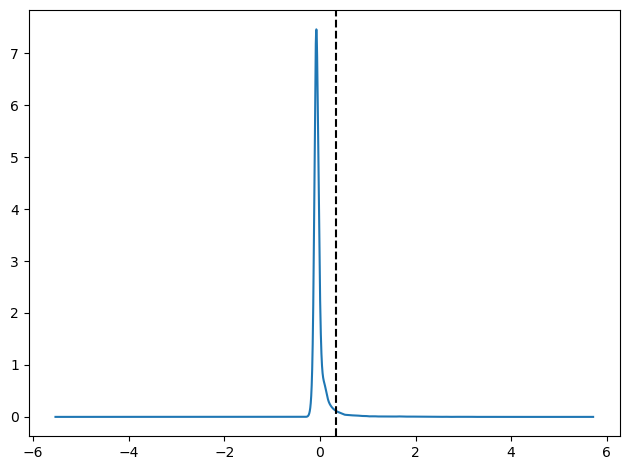

26227

In [25]:
pair = (("NEP_I34A1", "NRAM_I34A1"), (4, 5), 295)
get_contacts_numbers(pair, tensors, pairs_list, plot=True)


In [18]:
# Get the 6 best and 6 worst scores from string for the virus 

def best_woarst_scores(tsv_file, id_map) : 
    # Get the interactions dict
    interactions_full_path, _, _, _ = read_full_interaction_file(tsv_file)
    # Sort by STRING global score
    sorted_pairs = sorted(interactions_full_path.items(), key=lambda item: item[1][-1])

    reversed_id_map = {v: k for k, v in id_map.items()}


    worst_pairs = [(pair, scores[-1]) for pair, scores in sorted_pairs[:10]]
    best_pairs = [(pair, scores[-1]) for pair, scores in sorted_pairs[-10:]]

    worst_pairs = remove_pairs(worst_pairs)
    best_pairs = remove_pairs(best_pairs)
    
    worst_pairs = [((pair, (reversed_id_map[pair[0]],reversed_id_map[pair[1]]), scores)) for pair, scores in worst_pairs]
    best_pairs = [((pair, (reversed_id_map[pair[0]],reversed_id_map[pair[1]]), scores)) for pair, scores in best_pairs]

    return worst_pairs, best_pairs


    #return best_pairs, best_scores, worst_pairs, worst_scores

interactions_full_path = f'/home/thibaut/String/{virus_id}/virus_full_interactions.txt'

worst_pairs, best_pairs = best_worst_scores(interactions_full_path, id_map)

# Afficher les résultats
print("5 pires paires avec scores :", worst_pairs)
print("5 meilleures paires avec scores :", best_pairs)


FileNotFoundError: [Errno 2] No such file or directory: '/home/thibaut/String/test/virus_full_interactions.txt'

In [6]:
# Virus informations :
 
with open(global_viruses_file, 'r') as virus_file :
    for virus in virus_file : 
        if virus.startswith(virus_id) : 
            print(virus)

protein_count = []
with open(global_proteins_file, 'r') as protein_file : 
    for protein in protein_file : 
        if protein.startswith(virus_id) : 
            prot = protein.split()[0]
            if prot not in protein_count : 
                protein_count.append(prot)

print(f"The virus {virus_id} has {len(protein_count)} proteins")


11320	core	Influenza A virus (strain A/Puerto Rico/8/1934 H1N1)	Influenza A virus (strain A/Puerto Rico/8/1934 H1N1)

The virus 11320 has 12 proteins


In [8]:
# Generate fasta file for the virus : 
# Approx 2min to generate the 2 files

proteins_output = f"/home/thibaut/String/{virus_id}/proteins.fasta"
virus_output = f"/home/thibaut/String/{virus_id}/virus.fasta"

if os.path.exists(proteins_output) and os.path.exists(virus_output) : 
    print("Fasta files exist")
else :
    proteins_fasta(global_fasta_file, proteins_output, virus_id)
    virus_fasta(proteins_output, virus_output, virus_id)

Fasta files exist


In [9]:
# Get the virus links : 
# Approx 3min to generate the virus interaction file

interactions_output = f"/home/thibaut/String/{virus_id}/virus_full_interactions.txt"

if os.path.exists(interactions_output):
    print("Interaction file exists")
else : 
    full_interactions(global_links_file, interactions_output, virus_id)

Interaction file exists


In [10]:
def load_fasta_as_tuples(fasta_path):
    sequences = []
    # Parcourir chaque enregistrement du fichier FASTA
    for record in SeqIO.parse(fasta_path, "fasta"):
        record_str = str(record.seq)
        record.seq = Seq(record_str)
        sequences.append((record.id, str(record.seq)))

    return sequences

In [11]:
@profile
def apc(x):
    "Perform average product correct, used for contact prediction."
    a1 = x.sum(-1, keepdims=True)
    a2 = x.sum(-2, keepdims=True)
    a12 = x.sum((-1, -2), keepdims=True)

    avg = a1 * a2
    avg.div_(a12)  # in-place to reduce memory
    x.sub_(avg)    
    return x

def symmetrize(x):
    "Make layer symmetric in final two dimensions, used for contact prediction."
    return x + x.transpose(-1, -2)

In [12]:
# # Generate and store embeddings for the virus_output fasta file
# # Approx 1min for 4000 aa virus

# logging.getLogger("transformers").setLevel(logging.ERROR) 

# # Load data and tokenizer
# data = load_fasta_as_tuples(virus_output)
# print('data loaded')
# model_3b, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
# batch_converter = alphabet.get_batch_converter()
# print('alphabet loaded')

# # Create a folder to save the embeddings
# saving_folder = f"/home/thibaut/String/{virus_id}/embeddings/"
# if not os.path.exists(saving_folder):
#     os.makedirs(saving_folder)
# print('folder created')


# # Load esm2 model :
# base_model_path = "facebook/esm2_t33_650M_UR50D"
# model = EsmForSequenceClassification.from_pretrained(base_model_path, max_position_embeddings = 4000, ignore_mismatched_sizes=True, output_attentions = True)
# model = model.to(device)
# model.eval()
# print('esm2 base model loaded')

# # Load a fine-tuned model : 
# model_path = "/home/thibaut/fine-tunings-results/outputs-sliding-none/checkpoint-400/"
# loaded_model = PeftModel.from_pretrained(model, model_path, ignore_mismatched_sizes=True)
# loaded_model = loaded_model.to(device)
# loaded_model = loaded_model.eval()
# print('fine tuned model loaded')


# # Function to get the embeddings and attentions if needed : 
# def get_embeddings(batch_inputs,i):
#     attention_list = []
#     with torch.no_grad():
#         outputs = loaded_model(input_ids=batch_inputs) 
#         embeddings, attention_scores = outputs.logits.mean(dim=1), outputs.attentions
#         attention_list = list(attention_scores)
#         att_full = torch.cat(attention_list, dim=1)

#     return embeddings, att_full

# batch_size = 1

# for i in tqdm(range(0, len(data), batch_size)):

#     batch_labels, batch_strs, batch_tokens = batch_converter([data[i]])
#     batch_inputs = batch_tokens
#     batch_inputs = batch_inputs.to(device)
#     embeddings, attentions = get_embeddings(batch_inputs, i)
#     attentions.cpu()
#     attentions = attentions.to(dtype = torch.float16)

#     saving_path = saving_folder + f"virus_{i}_embeddings.pt"
#     torch.save(embeddings,saving_path)
#     saving_path_attentions = saving_folder + f"virus_{i}_full_attentions.pt"
#     torch.save(attentions,saving_path_attentions)

#     torch.cuda.empty_cache()



In [13]:
# Get and save the attentions for each pair of proteins

directory_path = f'/home/thibaut/String/{virus_id}/embeddings/sequence_0_mutual_information' #_apc'

if os.path.exists(directory_path) and os.listdir(directory_path) : 
    print('Folder exists')

else : 
    # might crash - to fix
    parsed_data = parse_fasta(proteins_output)
    print('Data parsed')
    base_embeddings_folder = f"/home/thibaut/String/{virus_id}/embeddings/"

    base_model_path = "facebook/esm2_t33_650M_UR50D"
    model = EsmForTokenClassification.from_pretrained(base_model_path)
    for name, param in model.named_parameters():
        if "contact_head" in name : 
            weights = param
            break

    process_sequences(parsed_data, base_embeddings_folder, weights)


Folder exists


In [12]:
# Count the contacts with count_contacts
#output_file_path = f"/home/thibaut/String/{virus_id}/results_freq.txt"
# Mutual_information_path 
#directory_path = f'/home/thibaut/String/{virus_id}/embeddings/sequence_0_mutual_information' #_apc'
freq_factor = 1
# Generate id_map
"""
id_map = {
    0: "HEMA_I34A1", 
    1: "M1_I34A1",
    2: "M2_I34A1", 
    3: "NCAP_I34A1", 
    4: "NEP_I34A1", 
    5: "NRAM_I34A1", 
    6: "NS1_I34A1", 
    7: "PAX_I34A1", 
    8: "PA_I34A1", 
    9: "PB1F2_I34A1", 
    10: "PB2_I34A1", 
    11: "RDRP_I34A1"
}
"""

id_map = get_id_map(global_fasta_file, virus_id)
virus_id = "11320"
tensors , pairs_list = count_contacts(output_file_path, directory_path, id_map, virus_id, freq_factor)

NameError: name 'get_id_map' is not defined

In [16]:
# Get the 6 best and 6 worst scores from string for the virus 

def best_worst_scores(tsv_file, id_map) : 
    # Get the interactions dict
    interactions_full_path, _, _, _ = read_full_interaction_file(tsv_file)
    # Sort by STRING global score
    sorted_pairs = sorted(interactions_full_path.items(), key=lambda item: item[1][-1])

    reversed_id_map = {v: k for k, v in id_map.items()}


    worst_pairs = [(pair, scores[-1]) for pair, scores in sorted_pairs[:10]]
    best_pairs = [(pair, scores[-1]) for pair, scores in sorted_pairs[-10:]]

    worst_pairs = remove_pairs(worst_pairs)
    best_pairs = remove_pairs(best_pairs)
    
    worst_pairs = [((pair, (reversed_id_map[pair[0]],reversed_id_map[pair[1]]), scores)) for pair, scores in worst_pairs]
    best_pairs = [((pair, (reversed_id_map[pair[0]],reversed_id_map[pair[1]]), scores)) for pair, scores in best_pairs]

    return worst_pairs, best_pairs


    #return best_pairs, best_scores, worst_pairs, worst_scores

interactions_full_path = f'/home/thibaut/String/{virus_id}/virus_full_interactions.txt'

worst_pairs, best_pairs = best_worst_scores(interactions_full_path, id_map)

# Afficher les résultats
print("5 pires paires avec scores :", worst_pairs)
print("5 meilleures paires avec scores :", best_pairs)


5 pires paires avec scores : [(('M1_I34A1', 'PB1F2_I34A1'), (1, 9), 177), (('M2_I34A1', 'PB1F2_I34A1'), (2, 9), 217), (('NRAM_I34A1', 'PB1F2_I34A1'), (5, 9), 255), (('HEMA_I34A1', 'PB1F2_I34A1'), (0, 9), 259), (('NS1_I34A1', 'PB1F2_I34A1'), (6, 9), 259)]
5 meilleures paires avec scores : [(('M1_I34A1', 'M2_I34A1'), (1, 2), 736), (('M1_I34A1', 'NRAM_I34A1'), (1, 5), 741), (('NEP_I34A1', 'PB2_I34A1'), (4, 10), 794), (('HEMA_I34A1', 'NCAP_I34A1'), (0, 3), 808), (('PB2_I34A1', 'RDRP_I34A1'), (10, 11), 926)]


In [34]:
from scipy.stats import gaussian_kde


def get_contacts_numbers(pair, tensors, pairs_list, plot = False):

    prot1, prot2 = pair[1][0], pair[1][1]
    attention_block = f"{prot1}_{prot2}_attention.pt"
    index = pairs_list.index(attention_block)

    last = tensors[index].reshape(1,-1).tolist()[0]

    x = np.linspace(min(last),max(last),len(last))
    g_kde = gaussian_kde(last)
    eval = g_kde.evaluate(x)

    fact = (max(last)-min(last))/len(last)
    masses = eval * fact
    cum = np.cumsum(masses)
    x_index_limit = sum(cum >= 0.95)

    threshold = x[x_index_limit]
    last_index_limit = sum(np.array(last) > threshold)


    if plot : 
        plt.plot(x, eval)
        plt.axvline(x=x[last_index_limit], color='black', linestyle='--', label='0.95')
        plt.tight_layout()
        plt.show()

    att_over_threshold = len(last) - last_index_limit

    return att_over_threshold

In [ ]:
# from scipy.stats import gaussian_kde
# from fastkde import fastKDE


# def get_fast_contacts_numbers(pair, tensors, pairs_list, plot = False):

#     prot1, prot2 = pair[1][0], pair[1][1]
#     attention_block = f"{prot1}_{prot2}_attention.pt"
#     index = pairs_list.index(attention_block)

#     last = tensors[index].reshape(1,-1).tolist()[0]

#     x = np.linspace(min(last),max(last),len(last))
#     eval, x = fastKDE(np.array(last))

#     fact = (max(last)-min(last))/len(last)
#     masses = eval * np.diff(x)[0]
#     cum = np.cumsum(masses)
#     x_index_limit = sum(cum >= 0.95)

#     threshold = x[x_index_limit]
#     last_index_limit = sum(np.array(last) > threshold)


#     if plot : 
#         plt.plot(x, eval)
#         plt.axvline(x=x[last_index_limit], color='black', linestyle='--', label='0.95')
#         plt.tight_layout()
#         plt.show()

#     att_over_threshold = len(last) - last_index_limit

#     return att_over_threshold

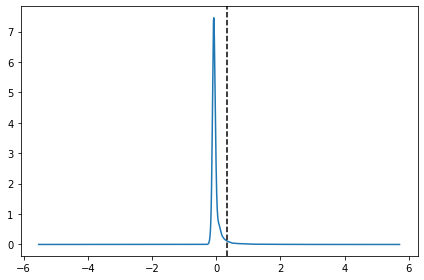

Timer unit: 1e-09 s

Total time: 34.1593 s
File: /tmp/ipykernel_1249920/1757996126.py
Function: get_contacts_numbers at line 4

Line #      Hits         Time  Per Hit   % Time  Line Contents
     4                                           def get_contacts_numbers(pair, tensors, pairs_list, plot = False):
     5                                           
     6         1       1011.0   1011.0      0.0      prot1, prot2 = pair[1][0], pair[1][1]
     7         1       1047.0   1047.0      0.0      attention_block = f"{prot1}_{prot2}_attention.pt"
     8         1       2190.0   2190.0      0.0      index = pairs_list.index(attention_block)
     9                                           
    10         1    1512336.0    2e+06      0.0      last = tensors[index].reshape(1,-1).tolist()[0]
    11                                           
    12         1    1847213.0    2e+06      0.0      x = np.linspace(min(last),max(last),len(last))
    13         1    4599435.0    5e+06      0.0      

In [35]:
from line_profiler import LineProfiler


profiler = LineProfiler()
profiler.add_function(get_contacts_numbers)
profiler.run('get_contacts_numbers((("NEP_I34A1", "NRAM_I34A1"), (4, 5), 295), tensors, pairs_list, plot=True)')
profiler.print_stats()


In [30]:
num = get_contacts_numbers((('NEP_I34A1', 'NRAM_I34A1'), (4, 5), 295), tensors, pairs_list, plot=True)
print(num)

TypeError: list indices must be integers or slices, not tuple

In [ ]:
print("5 pairs with the lowest String scores :")
for pair in worst_pairs : 
    num = get_contacts_numbers(pair, tensors, pairs_list, plot=False)
    print(f"Contacts entre {pair[0][0]} et {pair[0][1]} : String score = {pair[2]} / Kde score = {num}")

print("5 pairs with the best String scores :")
for pair in best_pairs : 
    num = get_contacts_numbers(pair, tensors, pairs_list, plot=False)
    print(f"Contacts entre {pair[0][0]} et {pair[0][1]} : String score = {pair[2]} / Kde score = {num}")

5 pairs with the lowest String scores :
Contacts entre M1_I34A1 et PB1F2_I34A1 : String score = 177 / Kde score = 21922
Contacts entre M2_I34A1 et PB1F2_I34A1 : String score = 217 / Kde score = 8437
Contacts entre NRAM_I34A1 et PB1F2_I34A1 : String score = 255 / Kde score = 3
Contacts entre HEMA_I34A1 et PB1F2_I34A1 : String score = 259 / Kde score = 12
Contacts entre NS1_I34A1 et PB1F2_I34A1 : String score = 259 / Kde score = 2792
5 pairs with the best String scores :
Contacts entre M1_I34A1 et M2_I34A1 : String score = 736 / Kde score = 24430
Contacts entre M1_I34A1 et NRAM_I34A1 : String score = 741 / Kde score = 86852
Contacts entre NEP_I34A1 et PB2_I34A1 : String score = 794 / Kde score = 90749


In [ ]:
def compare_and_extend(file1_path, file2_path, output_path):
    # Lire et stocker le contenu du premier fichier
    existing_pairs = set()
    with open(file1_path, 'r') as file1:
        file1_lines = file1.readlines()
        for line in file1_lines:
            parts = line.strip().split()
            # Création d'une paire ordonnée pour éviter les doublons inversés
            pair = tuple(parts[:2] + parts[2:4])
            existing_pairs.add(pair)
            # Ajout aussi de la paire inverse pour symétrie
            inverse_pair = tuple(parts[:2] + parts[3:1:-1])
            existing_pairs.add(inverse_pair)
    
    # Lire le second fichier et préparer les nouvelles lignes
    new_lines = []
    with open(file2_path, 'r') as file2:
        for line in file2:
            parts = line.strip().split()
            pair = tuple(parts[:2] + parts[2:4])
            inverse_pair = tuple(parts[:2] + parts[3:1:-1])
            if pair not in existing_pairs and inverse_pair not in existing_pairs:
                # Construire une nouvelle ligne avec des zéros
                new_line = ' '.join(parts[:4] + ['0']*11 + ['\n'])
                new_lines.append(new_line)
                # Ajouter la paire au set pour éviter les doublons
                existing_pairs.add(pair)
    
    # Écrire le contenu dans le nouveau fichier
    with open(output_path, 'w') as output_file:
        # Écrire les lignes du premier fichier
        output_file.writelines(file1_lines)
        # Écrire les nouvelles lignes
        output_file.writelines(new_lines)
    
    print(f"File has been created at {output_path} with the combined content.")



In [ ]:
# Final analysis with analyse_contacts (all_metrics)
results_path = f'/home/thibaut/String/{virus_id}/results_freq.txt'
interactions_full_path = f'/home/thibaut/String/{virus_id}/virus_full_interactions.txt'
distances_path = '/home/thibaut/String/Influenza/Influenza_A_sizes.txt'
extended_interactions_full = f'/home/thibaut/String/{virus_id}/combined_interactions.txt'
compare_and_extend(interactions_full_path, results_path, extended_interactions_full)

results_data, results_scores = read_interaction_file(results_path)
print(results_data)
interaction_data_full, interaction_mining_scores , interaction_exp_scores, interaction_scores_full = read_full_interaction_file(interactions_full_path)
print(interaction_data_full)
distances_data, distances_scores = read_interaction_file(distances_path)
string_tr = 300
model_tr = statistics.median(results_scores)/4

print(statistics.median(results_scores)/4)


all_metrics(results_data, results_scores, interaction_data_full, "complete_score", distances_data, distances_scores, string_tr, model_tr)

File has been created at /home/thibaut/String/11320/combined_interactions.txt with the combined content.
{('NS1_I34A1', 'PB1F2_I34A1'): 0.1891304347826087, ('M2_I34A1', 'NRAM_I34A1'): 2.3402061855670104, ('NCAP_I34A1', 'NS1_I34A1'): 0.23091966258608732, ('NEP_I34A1', 'RDRP_I34A1'): 3.128065022880951, ('M1_I34A1', 'NEP_I34A1'): 0.2400793650793651, ('NEP_I34A1', 'PB2_I34A1'): 3.136329485690868, ('PB2_I34A1', 'RDRP_I34A1'): 0.4986764014088297, ('HEMA_I34A1', 'NEP_I34A1'): 0.10707807972433236, ('M1_I34A1', 'PAX_I34A1'): 0.5, ('M2_I34A1', 'PAX_I34A1'): 1.2989690721649485, ('NS1_I34A1', 'PA_I34A1'): 1.5565028355387525, ('M2_I34A1', 'PB2_I34A1'): 3.9123179934105643, ('M2_I34A1', 'NS1_I34A1'): 1.1854607290891699, ('NCAP_I34A1', 'RDRP_I34A1'): 0.7600401606425703, ('HEMA_I34A1', 'PB1F2_I34A1'): 0.07698958414911113, ('M2_I34A1', 'PB1F2_I34A1'): 0.44840046763736846, ('HEMA_I34A1', 'NCAP_I34A1'): 0.4407048320150364, ('PAX_I34A1', 'PB2_I34A1'): 1.505952380952381, ('PA_I34A1', 'PB1F2_I34A1'): 0.06075